In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
sklearn.model_selection import 
# from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor

from utils import settings
from utils.preprocessing import data_processing_end, get_file_names, data_processing_us_bls
from utils.visualization import units, visualize_features
from utils.feature_selection import test_stationarity, remove_non_stationary_features, seasonal_decomposition
from utils.model_metrics import classification_metrics, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

# initialize the list of all settings to be used in this file
settings.init()

SEED = 450

## Data preparation

In [3]:
data = pd.read_csv("Data/dataset_monthly.csv", sep=';')
data_pct_change = pd.read_csv("Data/dataset_monthly_pct_change.csv", sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data_pct_change['Date'] = pd.to_datetime(data_pct_change['Date'])

settings.add('ORIGINAL_COLS', data.columns)  # names of raw features
settings.add('UNITS', units)  # units are in utils.visualization

data = pd.merge(data, data_pct_change, on='Date')

In [4]:
# handle political orientation categories: D = 1, R = 0
pol_columns = ['potus', 'houseOfRep', 'fedChair']
for col in pol_columns:
    data[col] = data[col] == 'D'

# create X and Y sets
Y_COL = ['FF month avg', 'FF spot EOM','FF growth rate', 'FF trend']
X, Y = data.drop(columns = Y_COL), data[Y_COL + ['Date']]

In [5]:
# Create two settings for non numeric features and numeric features
settings.add('NON_NUM_COLS', ['Date', 'Recession', 'potus', 'houseOfRep', 'fedChair'])  # non numeric features (boolean, date, etc)
settings.add('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])  # numeric features

# Exclude features without seasonality correction already implemented
settings.add('EXCL_COLS', [c for c in X.columns if c.lower().replace('_pct_change', '')[-5:] == 'unadj'])

# Remaining features for next steps in X (useful only for experiments)
settings.add('KEPT_COLS', list(X.columns))
# settings.remove_columns_names('KEPT_COLS', ['Date'])
settings.remove_columns_names('KEPT_COLS',settings.get('EXCL_COLS'))

X = X[settings.get('KEPT_COLS')]
X.describe()

,cpi_all_seas,cpi_energy_seas,cpi_less_energy_seas,empl_pop_ratio_seas,unempl_level_seas,unempl_rate_seas,EA19_GDP_gth_rate,EU27_2020_GDP_gth_rate,G-20_GDP_gth_rate,G-7_GDP_gth_rate,...,US debt share in GDP_pct_change,US debt nominal_pct_change,USDCNY_pct_change,EURUSD_pct_change,VIX_pct_change,GSPC(S&P500)_pct_change,trade_balance_All_pct_change,trade_balance_Goods_pct_change,trade_balance_Services_pct_change,WTI oil price_pct_change
count,868.000000,760.000000,760.000000,868.000000,868.000000,868.000000,299.000000,299.000000,263.000000,695.000000,...,650.000000,650.000000,340.000000,244.000000,364.000000,868.000000,339.000000,339.000000,339.000000,868.000000
mean,111.999953,105.167158,127.090921,59.259562,6512.306452,5.737558,0.356786,0.402189,0.881677,0.691432,...,0.004751,0.020227,0.001086,0.000958,0.019566,0.007038,0.020354,0.009265,0.006510,0.004480
std,78.020747,72.562924,77.183956,2.744295,3018.715065,1.673670,0.656951,0.631297,0.453653,0.636150,...,0.017610,0.014992,0.028054,0.028302,0.212794,0.041640,0.174109,0.070388,0.066756,0.081582
min,23.500000,21.300000,28.400000,51.300000,1596.000000,2.500000,-3.750627,-3.330070,-1.490590,-2.278271,...,-0.041096,-0.024336,-0.033474,-0.097206,-0.384898,-0.217630,-0.589832,-0.235778,-0.250081,-0.433413
25%,32.030000,27.775000,43.875000,57.000000,3955.250000,4.500000,0.193948,0.260195,0.739291,0.386459,...,-0.005590,0.010105,-0.002281,-0.014062,-0.110616,-0.017529,-0.046366,-0.030573,-0.017751,-0.000486
50%,102.750000,100.600000,123.350000,58.700000,6598.500000,5.500000,0.452963,0.506966,0.881462,0.626289,...,0.005118,0.021009,-0.000073,0.000262,-0.012708,0.009340,0.012985,0.007764,0.007379,0.000000
75%,178.700000,151.200000,194.475000,61.900000,8185.500000,6.800000,0.659003,0.703631,1.139417,1.055605,...,0.014055,0.029420,0.000145,0.018226,0.102586,0.034500,0.069123,0.049795,0.029449,0.020032
max,259.050000,271.149000,265.539000,64.700000,23078.000000,14.700000,1.286773,1.265028,1.469792,2.517170,...,0.087549,0.067379,0.500000,0.101047,1.345710,0.163047,2.178099,0.316025,0.341811,1.345708


## Data visualization

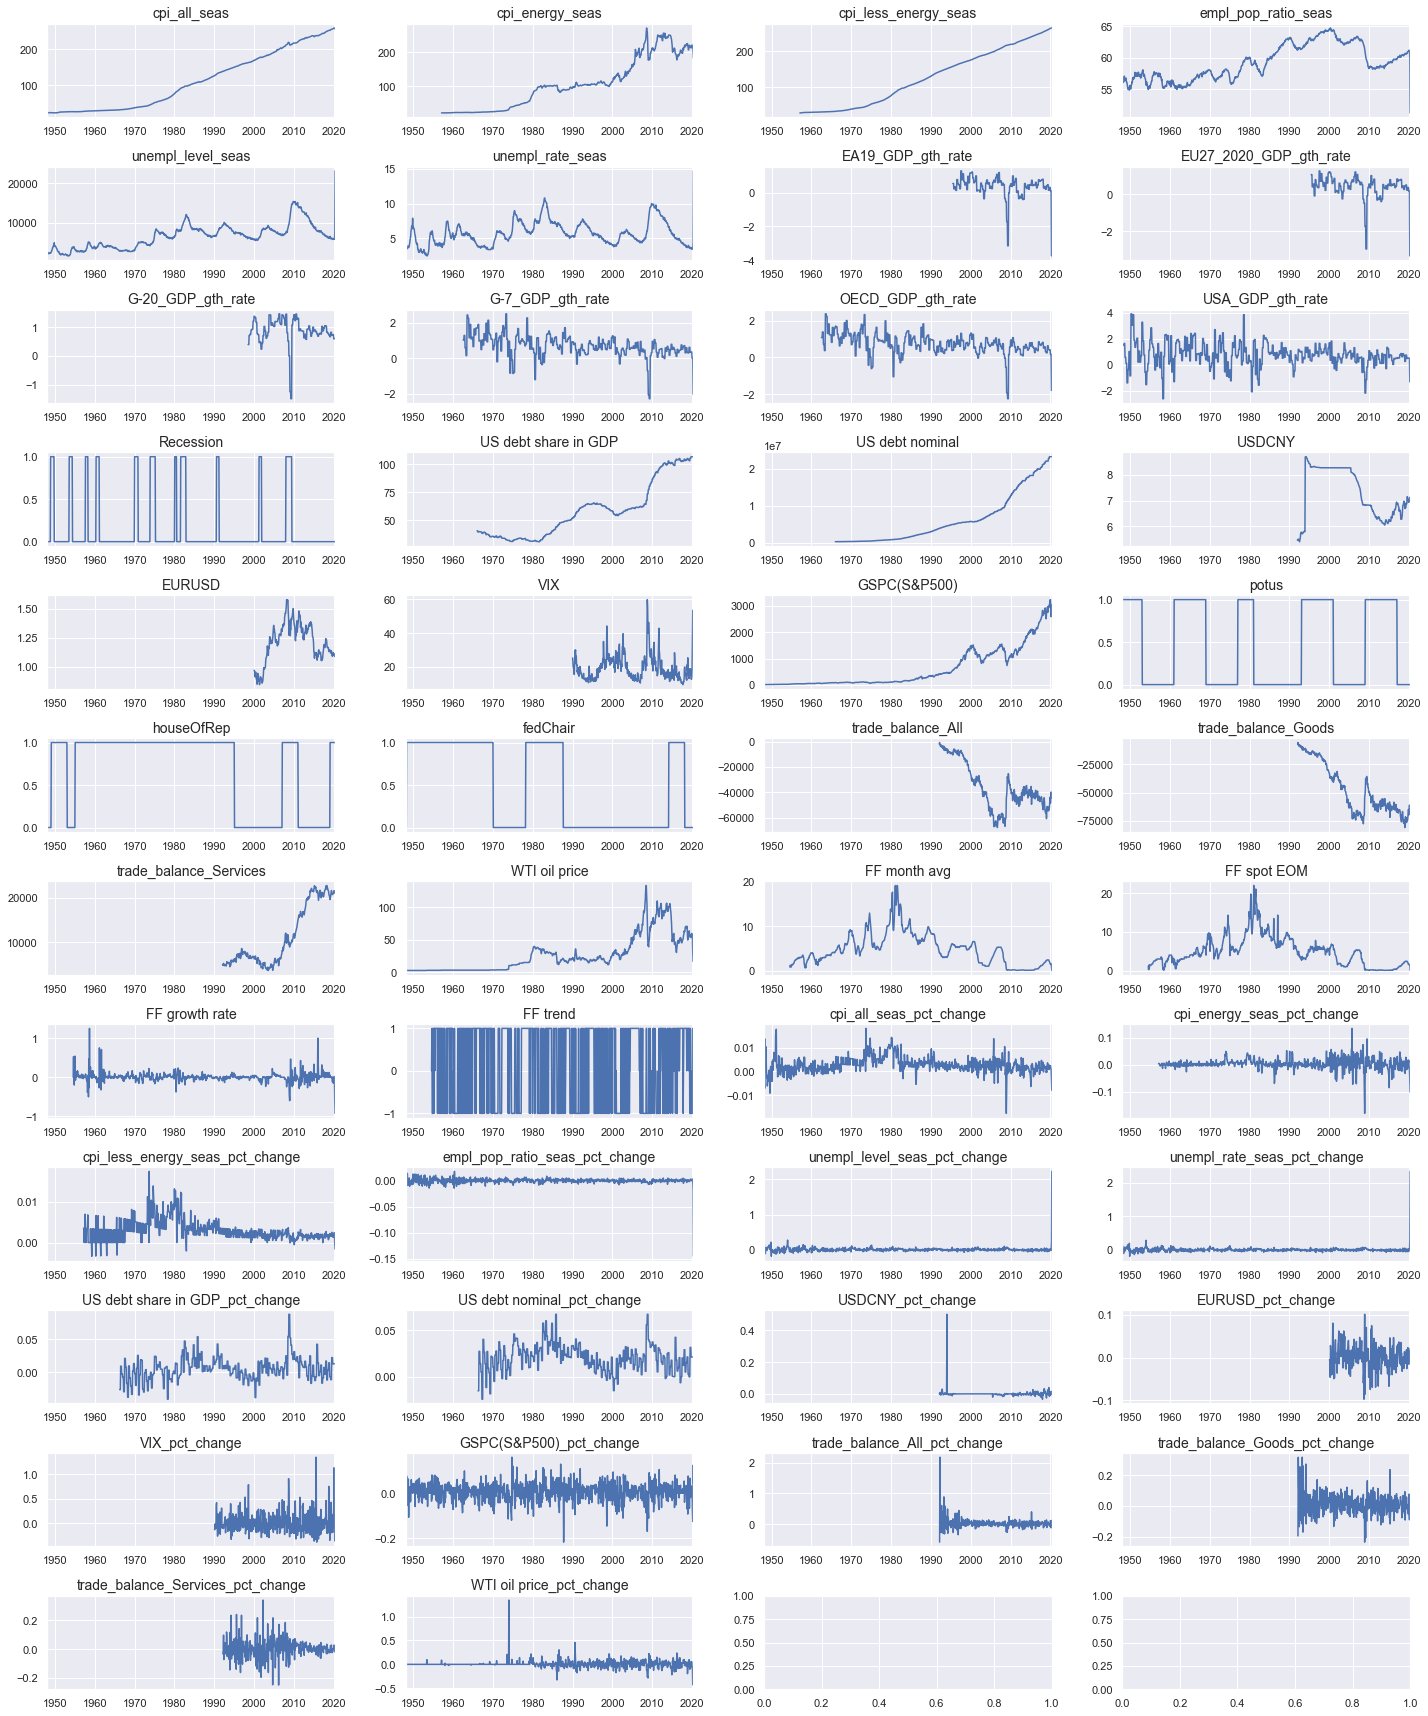

In [6]:
visualize_features(data=data,
                   excl_cols = settings.get('EXCL_COLS'),
                   date_col='Date',
                   ncols=4)

## Feature selection

### 1. Feature stationarity

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

#### Dickey-Fuller test to ensure stationarity of variables

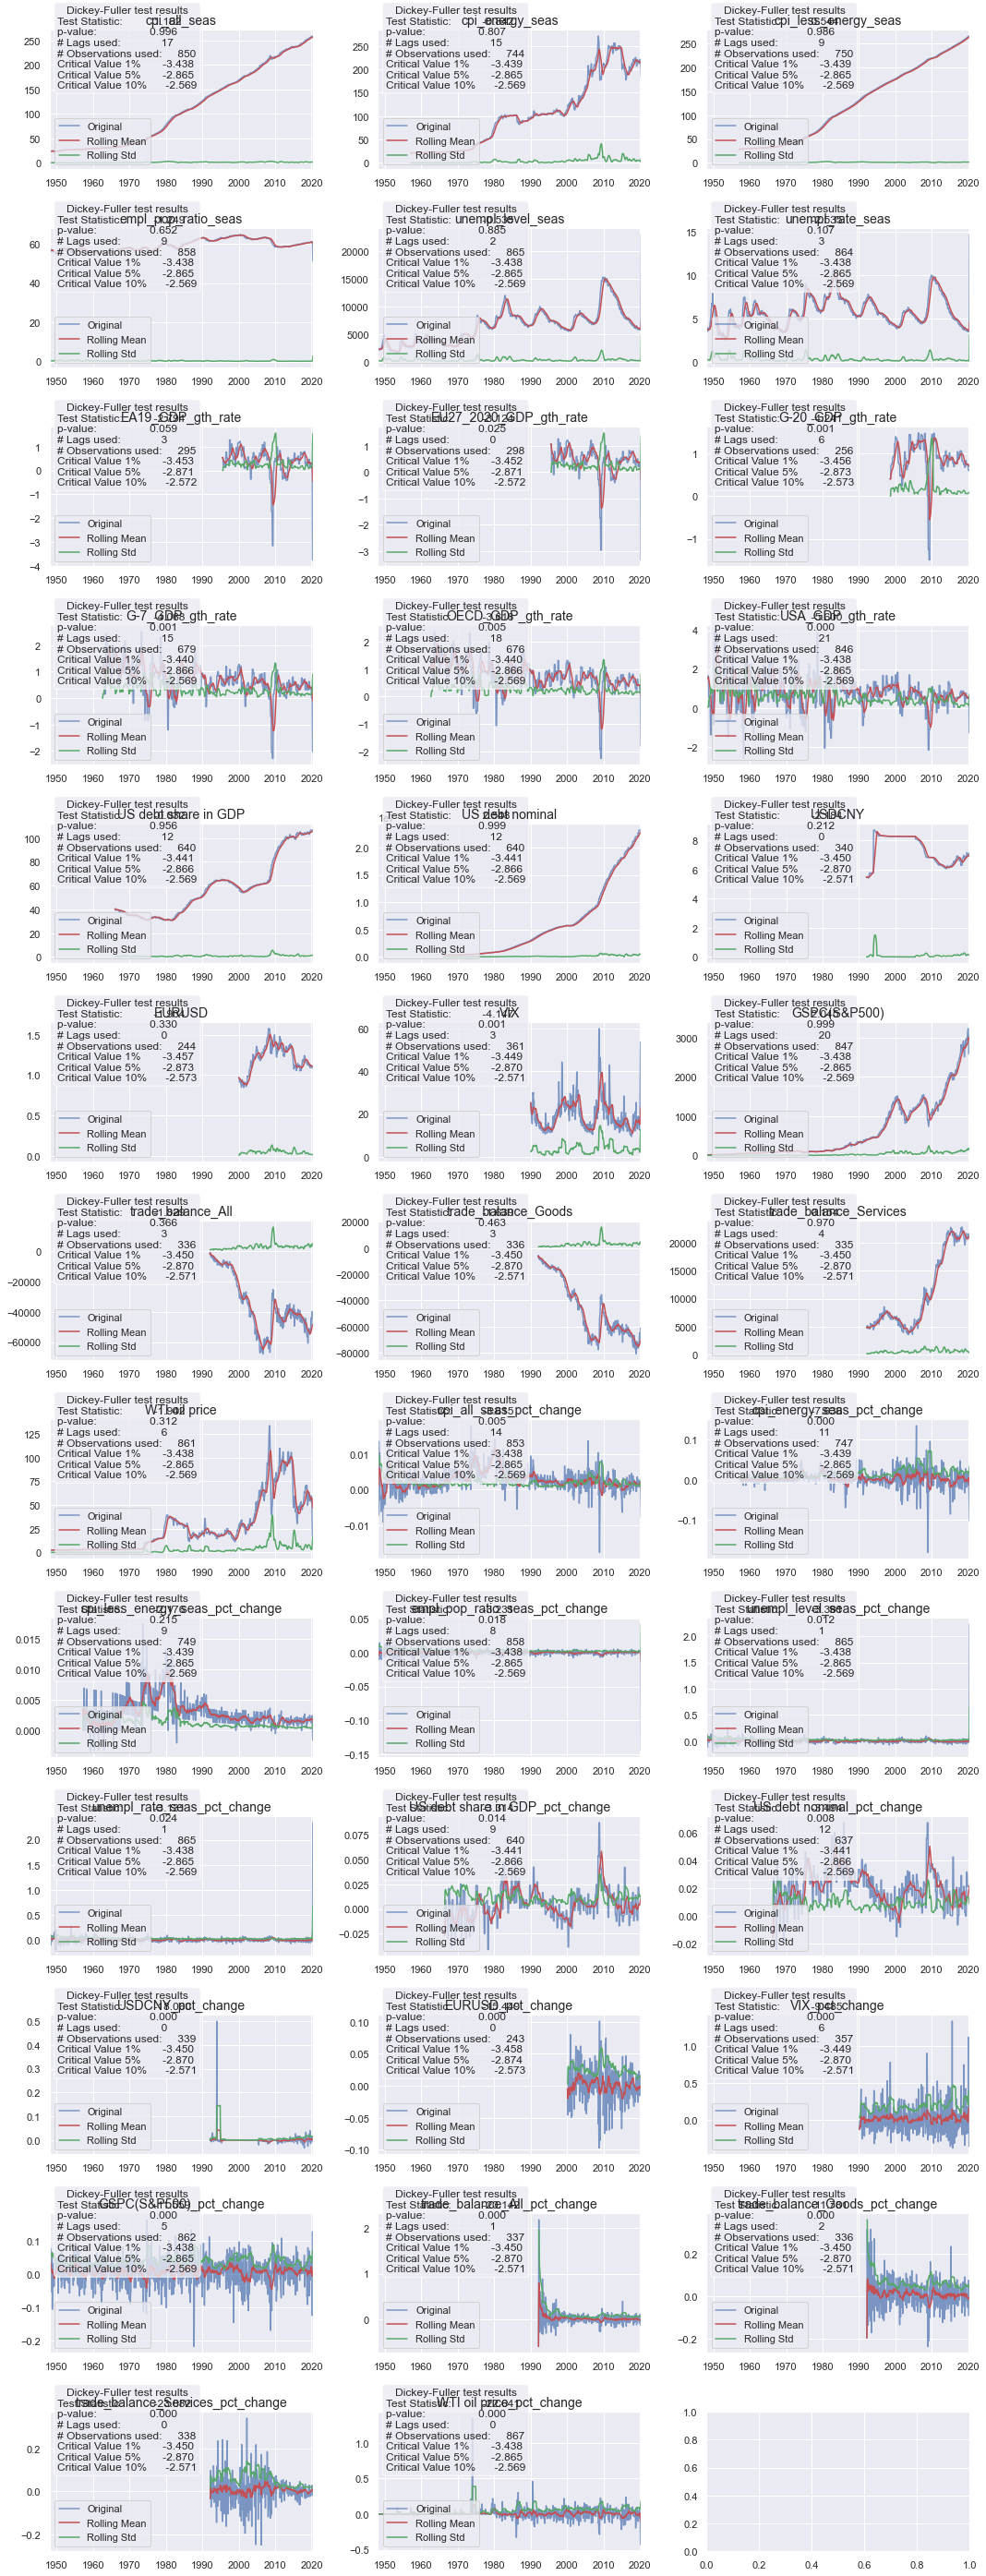

In [7]:
stat_results = test_stationarity(data,
                                columns=settings.get('NUM_COLS'),
                                excl_cols=settings.get('EXCL_COLS'),
                                date_col='Date',
                                stat_conf_level='5%',
                                height_per_ax=3,
                                print_graphs=True,
                                print_test_results=True,
                               )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [11]:
remove_non_stationary_features(X, stat_results)
X.describe()


Following features not found in provided dataframe:
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
unempl_rate_seas
EA19_GDP_gth_rate
US debt share in GDP
US debt nominal
USDCNY
EURUSD
VIX
GSPC(S&P500)
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI oil price


,EU27_2020_GDP_gth_rate,G-20_GDP_gth_rate,G-7_GDP_gth_rate,OECD_GDP_gth_rate,USA_GDP_gth_rate,VIX,cpi_all_seas_pct_change,cpi_energy_seas_pct_change,cpi_less_energy_seas_pct_change,empl_pop_ratio_seas_pct_change,...,unempl_rate_seas_pct_change,US debt share in GDP_pct_change,US debt nominal_pct_change,USDCNY_pct_change,EURUSD_pct_change,GSPC(S&P500)_pct_change,trade_balance_All_pct_change,trade_balance_Goods_pct_change,trade_balance_Services_pct_change,WTI oil price_pct_change
count,299.000000,263.000000,695.000000,695.000000,868.000000,365.000000,868.000000,759.000000,759.000000,867.000000,...,867.000000,650.000000,650.000000,340.000000,244.000000,868.000000,339.000000,339.000000,339.000000,868.000000
mean,0.402189,0.881677,0.691432,0.739806,0.780674,19.390959,0.002765,0.003052,0.002950,-0.000093,...,0.003751,0.004751,0.020227,0.001086,0.000958,0.007038,0.020354,0.009265,0.006510,0.004480
std,0.631297,0.453653,0.636150,0.587906,0.938514,7.657590,0.003338,0.020865,0.002514,0.006103,...,0.088649,0.017610,0.014992,0.028054,0.028302,0.041640,0.174109,0.070388,0.066756,0.081582
min,-3.330070,-1.490590,-2.278271,-2.255205,-2.595847,9.510000,-0.017705,-0.180245,-0.003356,-0.145000,...,-0.189873,-0.041096,-0.024336,-0.033474,-0.097206,-0.217630,-0.589832,-0.235778,-0.250081,-0.433413
25%,0.260195,0.739291,0.386459,0.443868,0.314515,13.700000,0.000992,-0.004175,0.001494,-0.001706,...,-0.021277,-0.005590,0.010105,-0.002281,-0.014062,-0.017529,-0.046366,-0.030573,-0.017751,-0.000486
50%,0.506966,0.881462,0.626289,0.719318,0.762672,17.370001,0.002417,0.003158,0.002440,0.000000,...,0.000000,0.005118,0.021009,-0.000073,0.000262,0.009340,0.012985,0.007764,0.007379,0.000000
75%,0.703631,1.139417,1.055605,1.072988,1.252567,23.379999,0.004253,0.009678,0.003647,0.001721,...,0.020204,0.014055,0.029420,0.000145,0.018226,0.034500,0.069123,0.049795,0.029449,0.020032
max,1.265028,1.469792,2.517170,2.369696,3.930121,59.889999,0.018100,0.134605,0.017429,0.018051,...,2.340909,0.087549,0.067379,0.500000,0.101047,0.163047,2.178099,0.316025,0.341811,1.345708


In [13]:
X[['Date', 'EURUSD_pct_change']].dropna().describe(include='all')

,Date,EURUSD_pct_change
count,244,244.000000
unique,244,NaN
top,2017-11-30 00:00:00,NaN
freq,1,NaN
first,2000-01-31 00:00:00,NaN
last,2020-04-30 00:00:00,NaN
mean,NaN,0.000958
std,NaN,0.028302
min,NaN,-0.097206
25%,NaN,-0.014062


### 3. Feature correlation

In [15]:
# set important dates for X and Y
settings.add('START_DATE', dt.datetime(2000, 1, 1))
settings.add('END_DATE', dt.datetime(2019, 12, 1))

In [16]:
# Only after START DATE
X = X.loc[(X['Date'] >= settings.get('START_DATE')) & (X['Date'] <= settings.get('END_DATE'))]
Y = Y.iloc[X.index]
print(X.head())

# Removing features with NaN after STARTDATE
X = X.dropna(axis=1)

# Ensuring Y has values everywhere
# Y = Y.dropna()
# X = X.iloc[Y.index]

          Date  EU27_2020_GDP_gth_rate  G-20_GDP_gth_rate  G-7_GDP_gth_rate  \
624 2000-01-31                1.220662           1.381790          1.272949   
625 2000-02-29                1.220662           1.381790          1.272949   
626 2000-03-31                1.154547           1.334709          0.881404   
627 2000-04-30                1.154547           1.334709          0.881404   
628 2000-05-31                1.154547           1.334709          0.881404   

     OECD_GDP_gth_rate  USA_GDP_gth_rate  Recession        VIX  potus  \
624           1.317520          1.699585      False  23.370001   True   
625           1.317520          1.699585      False  24.110001   True   
626           0.981673          0.361760      False  26.200001   True   
627           0.981673          0.361760      False  23.650000   True   
628           0.981673          0.361760      False  19.540001   True   

     houseOfRep  ...  unempl_rate_seas_pct_change  \
624       False  ...             

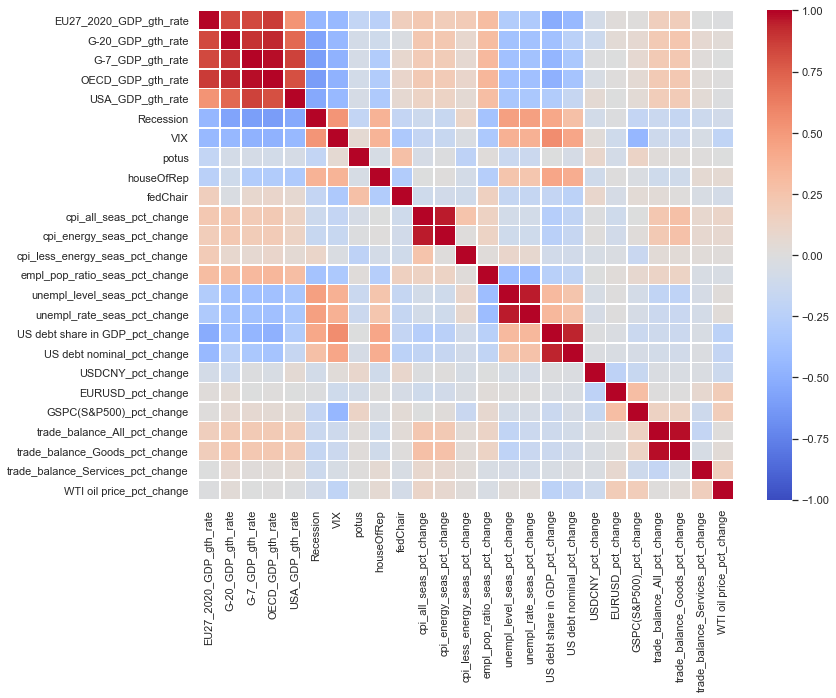

In [17]:
fig = plt.figure(figsize = (12, 9))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

In [20]:
columns_vif = [x for x in X.columns if x in settings.get('NUM_COLS')]

# Exclude features based on previous VIF analysis (iterative process)
excl_columns_vif = []
excl_columns_vif += ['cpi_all_seas_pct_change', 'G-7_GDP_gth_rate', 'US debt nominal_pct_change',
                     'unempl_level_seas_pct_change', 'OECD_GDP_gth_rate', 'trade_balance_All_pct_change']
# [, , ,
#                     'empl_pop_ratio_seas_pct_change', ]
# ['unempl_level_seas_pct_change', ,
#                      'cpi_all_seas_pct_change', , ,
#                      ]

# Compute features to be analysed by VIF
for e in excl_columns_vif:
    try: 
        columns_vif.remove(e)
    except: pass


In [21]:
data_vif = X[columns_vif]
data_vif = data_vif.dropna()
VIF_factor = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]
vif = pd.DataFrame({"VIF_factor": VIF_factor, "features": data_vif.columns})
print(vif)

    VIF_factor                           features
0     6.027351             EU27_2020_GDP_gth_rate
1    20.588887                  G-20_GDP_gth_rate
2     4.270274                   USA_GDP_gth_rate
3     8.292670                                VIX
4     1.195440         cpi_energy_seas_pct_change
5     5.421152    cpi_less_energy_seas_pct_change
6     1.319222     empl_pop_ratio_seas_pct_change
7     1.465359        unempl_rate_seas_pct_change
8     2.240856    US debt share in GDP_pct_change
9     1.133231                  USDCNY_pct_change
10    1.184036                  EURUSD_pct_change
11    1.363320            GSPC(S&P500)_pct_change
12    1.145378     trade_balance_Goods_pct_change
13    1.121825  trade_balance_Services_pct_change
14    1.218538           WTI oil price_pct_change


In [22]:
try:
    X.drop(columns=excl_columns_vif, inplace=True)
except KeyError:
    print("Some or all of these columns have already been removed")

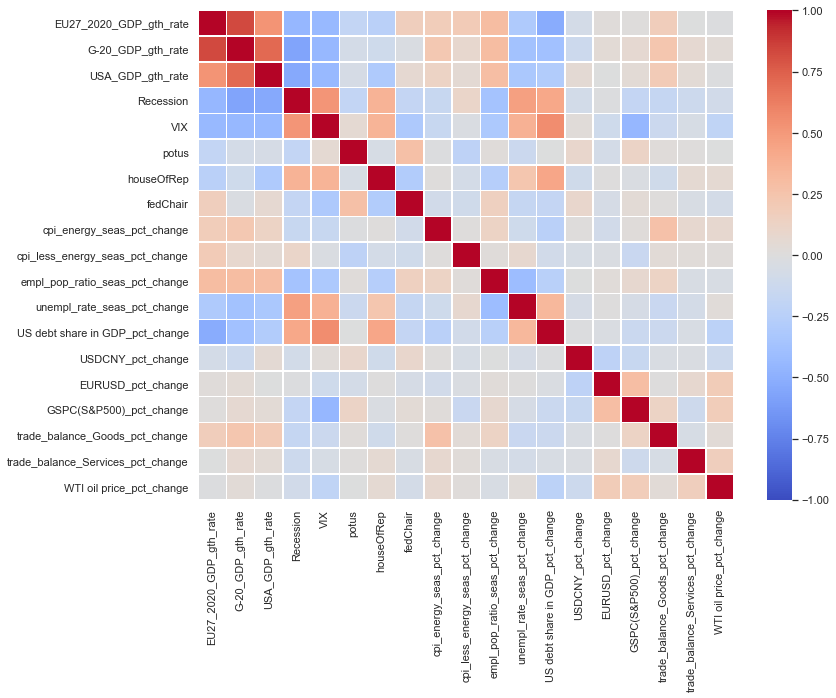

In [23]:
fig = plt.figure(figsize = (12, 9))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

## First models

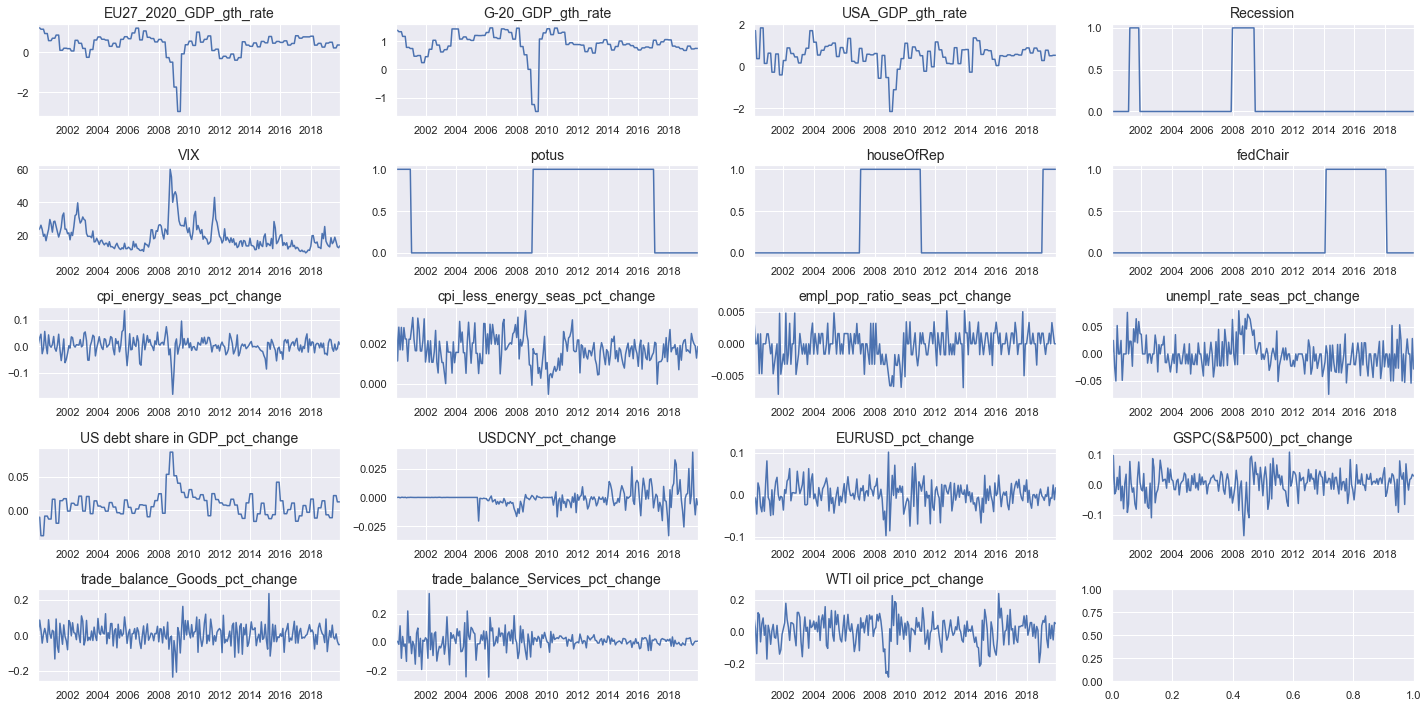

In [24]:
visualize_features(data=X,
         date_col='Date',
         ncols=4)

In [26]:
settings.add('TEST_DATE', dt.datetime(2014, 1, 1))

X_train, X_test = X.loc[X['Date'] < settings.get('TEST_DATE')], X.loc[X['Date'] >= settings.get('TEST_DATE')]
Y_train, Y_test = Y.loc[Y['Date'] < settings.get('TEST_DATE')], Y.loc[Y['Date'] >= settings.get('TEST_DATE')]
X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

In [27]:
def print_model_metrics(X_train, X_test, Y_train, Y_test, predict_col, model):
    print('Training score:', model.score(X_train, Y_train[predict_col]))
    print('Test score:', model.score(X_test, Y_test[predict_col]))
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    plt.figure(figsize=(16, 6))
    plt.plot(Y_train['Date'], Y_train[predict_col], label='Y_train')
    plt.plot(Y_train['Date'], pd.DataFrame(pred_train), label='Predictions - training')
    plt.plot(Y_test['Date'], Y_test[predict_col], label='Y_test')
    plt.plot(Y_test['Date'], pd.DataFrame(pred_test), label='Predictions - test')
    plt.legend()
    plt.show()

In [28]:
predict_col = 'FF growth rate'

In [ ]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = np.arange(1, len(X_train.columns))
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf
              }
rfc = RandomForestRegressor(random_state=SEED,)
rf_random_cv = GridSearchCV(estimator = rfc,
                                  param_grid = random_grid,
                                  cv = 5,
                                  verbose=5,
                                  n_jobs = -1  # parrallelize all
                                 )

# Fit the random search model
rf_random_cv.fit(X_train, Y_train[predict_col])

print("Best accuracy {:.4f} obtained for params {:s}".format(rf_random_cv.best_score_, str(rf_random_cv.best_params_)))

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.3min


In [20]:
# rf_random_cv.cv_results_

In [24]:
rfc = rf_random_cv.best_estimator_
rfc = rfc.fit(X_train, Y_train[predict_col])

Training score: 0.7328721769853481
Test score: -0.18260505723773313


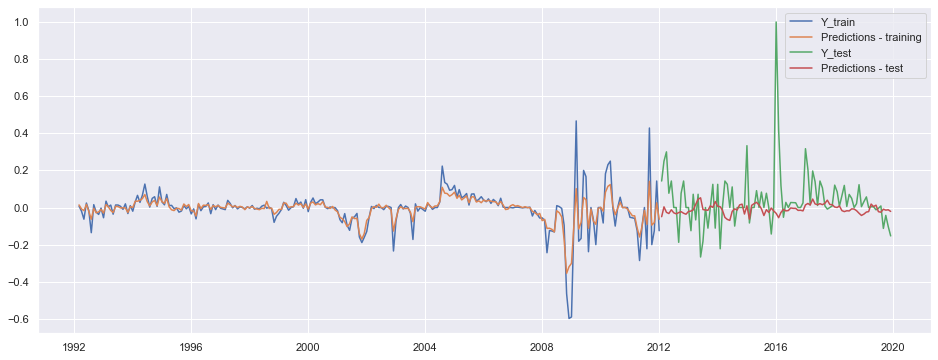

In [26]:
# print_model(X_train, X_test, Y_train, Y_test, predict_col, LinearRegression().fit(X_train, Y_train[predict_col]))
print_model(X_train, X_test, Y_train, Y_test, predict_col, rfc)

In [23]:
# lda = LinearDiscriminantAnalysis().fit(X_train, Y_train[predict_col])
X_train.columns

Index(['cpi_energy_seas_pct_change', 'cpi_less_energy_seas_pct_change',
       'unempl_rate_seas_pct_change', 'OECD_GDP_gth_rate', 'USA_GDP_gth_rate',
       'Recession', 'US debt share in GDP_pct_change', 'USDCNY_pct_change',
       'VIX', 'GSPC(S&P500)_pct_change', 'potus', 'houseOfRep', 'fedChair',
       'WTI oil price_pct_change'],
      dtype='object')

In [ ]:
def time_series_split_cv(n_splits, X_train, Y_train,
                         estimator=RandomForestRegressor(random_state=SEED),
                         type_of_search='GridSearchCV',
                         params_cv={},
                         cv=5,
                         n_iter=None
                        ):
    tscv = TimeSeriesSplit(n_splits=5)
    i = 1
    score = []
    for tr_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train[tr_index], X_train[val_index]
        y_tr, y_val = Y_train[tr_index], Y_train[val_index]
        for mf in np.linspace(100, 150, 6):
            if type_of_search == 'GridSearchCV':
                model_cv = GridSearchCV(estimator = estimator,
                                        param_grid = params_cv,
                                        cv = cv,
                                        verbose = 5,
                                        n_jobs = -1  # parrallelize all
                                        )
            elif type_of_search == 'RandomizedSearchCV':
                model_cv = RandomizedSearchCV(estimator = estimator,
                                              param_distributions = params_cv,
                                              cv = cv,
                                              verbose = 5,
                                              random_state = SEED,
                                              n_jobs = -1  # parrallelize all
                                             )
            model_cv.fit(X_tr, y_tr)
            score.append([i,
                        mf, 
                        ne,
                        md, 
                        msl,
                        model_cv.score(X_val, y_val)])
        i += 1
        return score

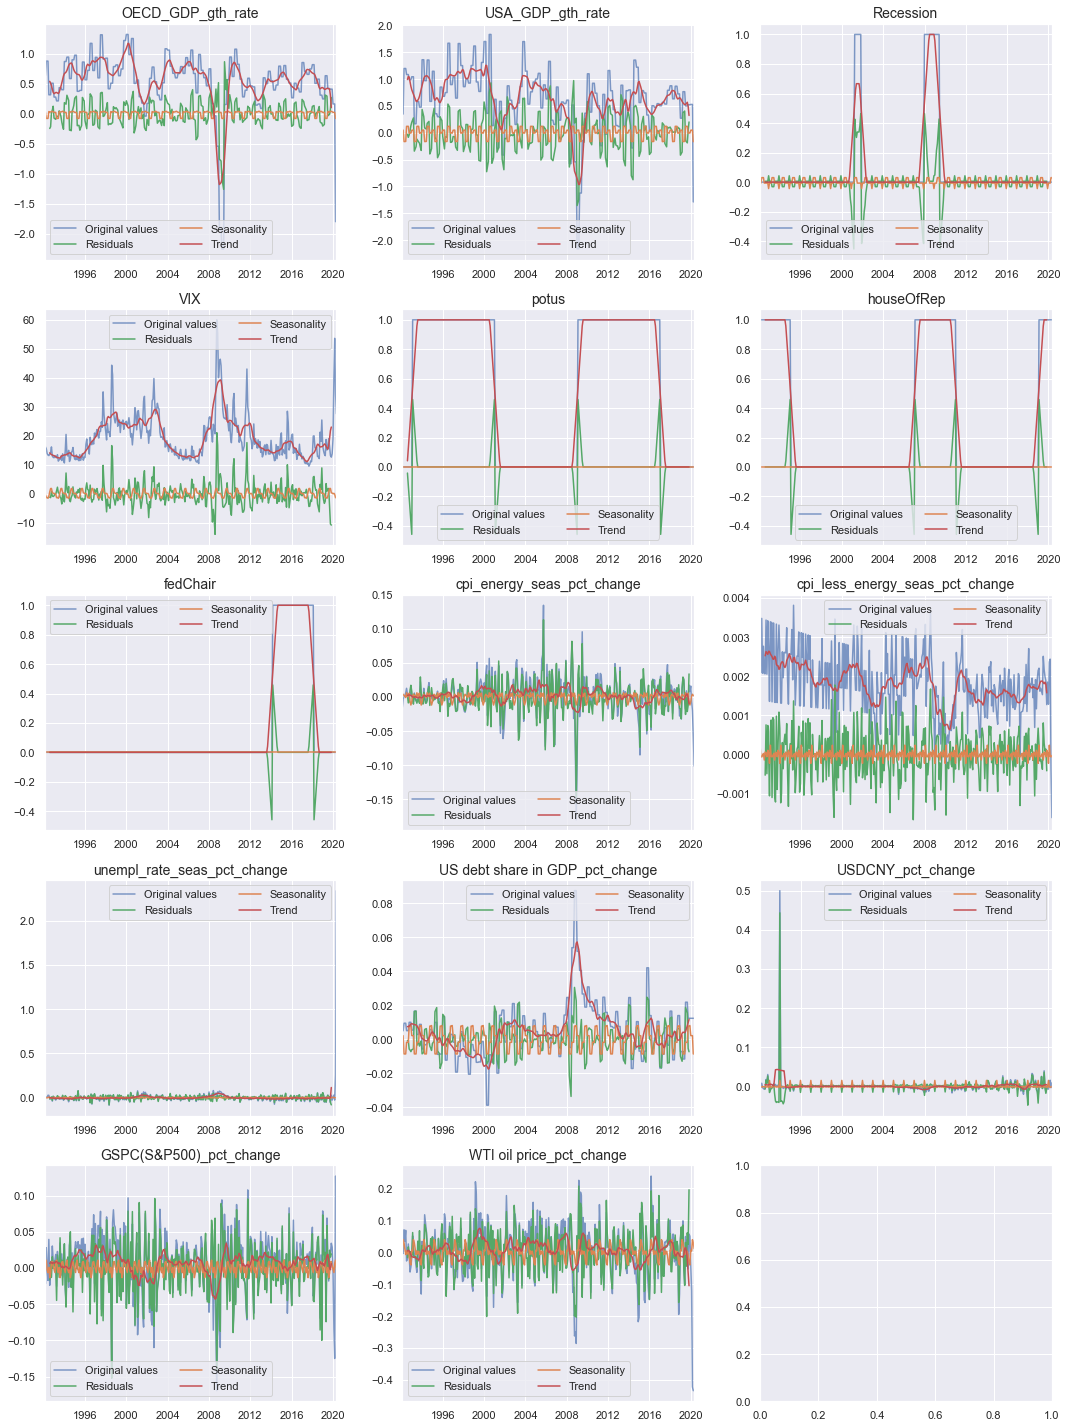

,Date,OECD_GDP_gth_rate_residual,USA_GDP_gth_rate_residual,Recession_residual,VIX_residual,potus_residual,houseOfRep_residual,fedChair_residual,cpi_energy_seas_pct_change_residual,cpi_less_energy_seas_pct_change_residual,unempl_rate_seas_pct_change_residual,US debt share in GDP_pct_change_residual,USDCNY_pct_change_residual,GSPC(S&P500)_pct_change_residual,WTI oil price_pct_change_residual
6,1992-07-31,-0.248504,-0.027694,0.006026,-1.142140,-0.041667,-2.066478e-16,9.897408e-19,0.000979,-0.000524,-0.014577,-0.000669,-0.007012,-0.016674,-0.017053
7,1992-08-31,-0.219970,-0.085050,0.006026,-1.317571,-0.125000,-2.091260e-16,4.954823e-18,-0.008664,0.000760,-0.009888,-0.000679,0.015175,0.008438,0.016717
8,1992-09-30,0.010205,-0.038491,0.006026,0.797399,-0.208333,-2.130910e-16,3.715735e-18,-0.007419,-0.000488,0.008644,-0.005656,0.007862,-0.013171,-0.003137
9,1992-10-31,0.057474,0.039922,0.006026,-0.753390,-0.291667,-2.130910e-16,1.733194e-18,0.010197,0.000744,-0.031056,-0.006241,0.026500,0.015358,-0.027052
10,1992-11-30,0.121862,0.131830,0.043283,-0.925209,-0.375000,-2.235177e-16,2.687751e-18,0.017153,0.000041,0.015575,-0.007168,0.004334,-0.000442,0.002101


In [25]:
df_trend, df_seas, df_resid = seasonal_decomposition(X, date_col='Date', print_graphs=True)
df_resid.dropna().head()

### 2. Feature normalization

In [27]:
# X_scaled = preprocessing.StandardScaler().fit_transform(X)
# X[settings.get('NUM_COLS')] = pd.DataFrame(X_scaled, columns=settings.get('NUM_COLS'))
# X.head()

TypeError: float() argument must be a string or a number, not 'Timestamp'